# Exploratory Data Analysis (EDA) of Benchmark Tools

In this analysis, we will explore the benchmark results of three tools: `rdfgraphgen`, `lubm`, and `rudof`. We will also calculate the triples throughput for each run, defined as the number of triples processed per second.


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv('all_benchmarks_joined.csv')
df.head()


,run,time_seconds,triples,source_file,tool
0,1,73.641365,67480,rdfgraphgen_benchmark_results.csv,rdfgraphgen
1,2,73.565330,67457,rdfgraphgen_benchmark_results.csv,rdfgraphgen
2,3,71.471091,67504,rdfgraphgen_benchmark_results.csv,rdfgraphgen
3,4,71.655589,67504,rdfgraphgen_benchmark_results.csv,rdfgraphgen
4,5,70.688710,67477,rdfgraphgen_benchmark_results.csv,rdfgraphgen


In [6]:
# Calculate triples throughput (triples per second)
df['triples_throughput'] = df['triples'] / df['time_seconds']

# Show basic statistics by tool
df.groupby('tool')[['time_seconds', 'triples', 'triples_throughput']].describe()


time_seconds                                             \
                   count       mean       std        min        25%   
tool                                                                  
lubm                30.0   7.726349  0.115817   7.342417   7.670832   
rdfgraphgen         30.0  71.284176  1.092418  69.487401  70.558531   
rudof               30.0   5.478522  0.086388   5.361443   5.413070   

                                             triples                ...  \
                   50%        75%        max   count          mean  ...   
tool                                                                ...   
lubm          7.720851   7.800614   7.975522    30.0  1.316322e+06  ...   
rdfgraphgen  70.700370  71.651070  73.641365    30.0  6.749410e+04  ...   
rudof         5.468270   5.508498   5.746409    30.0  3.031632e+05  ...   

                                  triples_throughput                 \
                   75%        max              count           mean   
tool                                                                  
lubm         1316322.0  1316322.0               30.0  170405.467071   
rdfgraphgen    67518.5    67575.0               30.0     947.046648   
rudof         303166.0   303174.0               30.0   55349.722409   

                                                                       \
                     std            min            25%            50%   
tool                                                                    
lubm         2593.001839  165045.256208  168745.958496  170489.235766   
rdfgraphgen    14.539784     916.332830     941.476426     954.311339   
rudof         856.633033   52757.467291   55034.868091   55439.658818   

                                           
                       75%            max  
tool                                       
lubm         171600.940289  179276.399744  
rdfgraphgen     956.626909     971.672555  
rudof         56005.165049   56547.094858  

[3 rows x 24 columns]

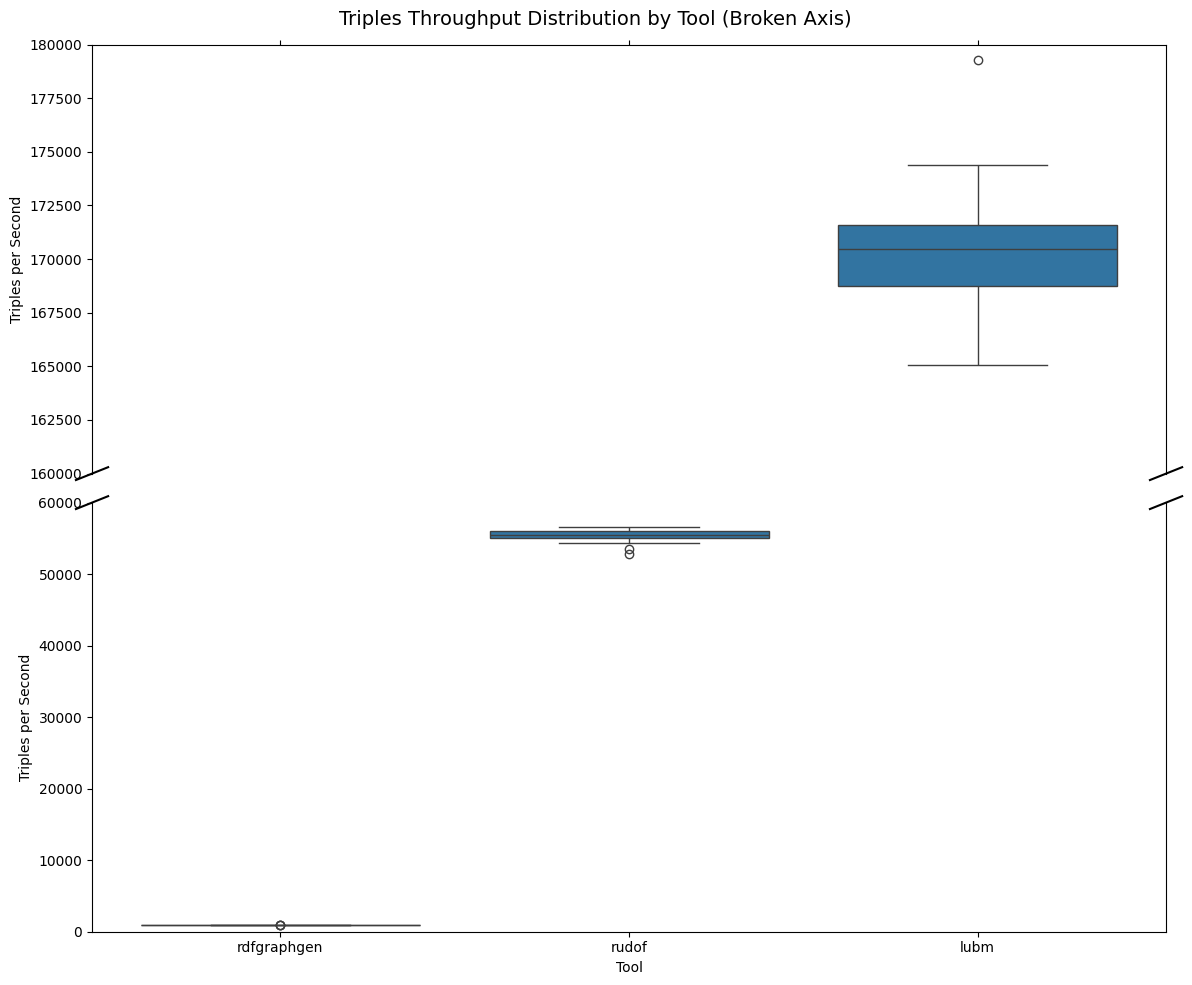

In [7]:
# Ensure 'lubm' is the last category for plotting
tool_order = [tool for tool in df['tool'].unique() if tool != 'lubm'] + ['lubm']
df['tool'] = pd.Categorical(df['tool'], categories=tool_order, ordered=True)

# Create broken axis plot to better show the differences
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot the same data on both axes
sns.boxplot(x='tool', y='triples_throughput', data=df, ax=ax1)
sns.boxplot(x='tool', y='triples_throughput', data=df, ax=ax2)

# Set different y-axis limits for each subplot
ax1.set_ylim(160000, 180000)  # Upper range for LUBM
ax2.set_ylim(0, 60000)       # Lower range for RDFGraphGen and RUDOF

# Hide the spines between ax1 and ax2
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

# Add diagonal lines to indicate the break
d = .015  # how big to make the diagonal lines in axes coordinates
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

# Set labels and title
fig.suptitle('Triples Throughput Distribution by Tool (Broken Axis)', fontsize=14)
ax2.set_xlabel('Tool')
ax1.set_ylabel('Triples per Second')
ax2.set_ylabel('Triples per Second')

plt.tight_layout()
plt.show()


## ANOVA Test for Triples Throughput

We will perform a one-way ANOVA (Analysis of Variance) test to determine if there are any statistically significant differences in the mean triples throughput among the different tools (`rdfgraphgen`, `lubm`, `rudof`).

- **Null Hypothesis (H0):** The mean triples throughput is the same for all tools.
- **Alternative Hypothesis (H1):** At least one tool has a different mean triples throughput.


In [8]:
import scipy.stats as stats

# Group data by tool for ANOVA
rdfgraphgen_throughput = df[df['tool'] == 'rdfgraphgen']['triples_throughput']
lubm_throughput = df[df['tool'] == 'lubm']['triples_throughput']
rudof_throughput = df[df['tool'] == 'rudof']['triples_throughput']

# Perform one-way ANOVA
f_statistic, p_value = stats.f_oneway(rdfgraphgen_throughput, lubm_throughput, rudof_throughput)

print(f"ANOVA F-statistic: {f_statistic}")
print(f"ANOVA P-value: {p_value}")

alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a statistically significant difference in mean triples throughput among the tools.")
else:
    print("Fail to reject the null hypothesis: There is no statistically significant difference in mean triples throughput among the tools.")


ANOVA F-statistic: 90336.88285796005
ANOVA P-value: 4.842347930310478e-145
Reject the null hypothesis: There is a statistically significant difference in mean triples throughput among the tools.
